In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchvision import datasets
import matplotlib.pyplot as plt

# Import Data #

In [2]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


10000
0


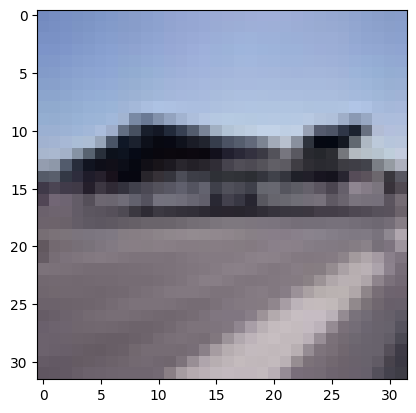

In [3]:
print(len(cifar10_val))
img, label = cifar10[10010]
print(label)
plt.imshow(img)
plt.show()

## Preprocessing Data ## 

In [5]:
# change all image data into tensor and stack them together into a large 4D tensor, 
# calculate the mean of the data
totensor = transforms.ToTensor()
tensor_x_cifar10 = torch.stack([totensor(i) for i,_ in cifar10],dim = 3)
tensor_y_cifar10 = torch.stack([torch.tensor(i) for _,i in cifar10])
mean = tensor_x_cifar10.view(3,-1).mean(dim=1)
std = tensor_x_cifar10.view(3,-1).std(dim=1)

In [6]:
mean.data, std.data 
# show mean and std
# for further reimporting transformed & normalized data
# this reimporting apporach only works for torch official dataset

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [7]:
# set transforming metrics and reimport
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]
                               )
data_path = '../data-unversioned/p1ch7/'
training_Set = datasets.CIFAR10(data_path, train=True, download=True,transform=transform)
testing_Set = datasets.CIFAR10(data_path,train=False,download=True,transform=transform)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Torch Dataset ##

In [83]:
# Customized Dataset class that retrieves data and return tensor class of data and label
totensor = transforms.ToTensor()  # turn image into tensor of the correct shape (3,32,32)
class cifar10Dataset(Dataset):
    def __init__(self,data):
        self.data = data
    def __getitem__(self,idx):
        img,label = self.data[idx]
        label = torch.tensor(label)
        # img = img.view(-1).unsqueeze(0)  # 把img展开成为一个1*3072的2D tensor
        # img = torch.flatten(img)
        return img, label
    def __len__(self):
        return len(self.data)   
        
trainData = cifar10Dataset(training_Set) # 实例化
testData = cifar10Dataset(testing_Set)

## Random Spilt by Torch utils ## 

In [84]:
torch.manual_seed(0)  # 随机种子
train_len, val_len = [int(len(trainData)*0.7),int(len(trainData)*0.3)]  # 一定要是int的split长度
test_len = int(len(testData)*0.9) 
trash_len = int(len(testData)*0.1) 
x_train, x_val = torch.utils.data.random_split(dataset=trainData,lengths=[train_len,val_len])  # 长度信息只能传入list
x_test,x_trash = torch.utils.data.random_split(dataset=testData,lengths=[test_len,trash_len]) 
#返回数组,所以设置trash_len,让testdata不是一个数组里的数组

In [85]:
x_train_dataloader = DataLoader(x_train, batch_size=128,shuffle=True)
x_val_dataloader = DataLoader(x_val,batch_size=128,shuffle=True)
x_test_dataloader = DataLoader(x_test,batch_size=128,shuffle=True)

# Model Set Up #

## Multilayer Perceptron - MLP ##

In [11]:
nin_mlp = 3072
nout = 10

In [72]:
class MLP(nn.Module):
    def __init__(self,nout):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3072,512),
            nn.Tanh(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,128),
            nn.Tanh(),
            nn.Linear(128,nout)
        )
    def forward(self,X):
        out = self.model(X)
        return out

## Convolutional Neural Network ## 

In [86]:
class CNN(nn.Module):
    def __init__(self,nout):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, nout)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



# Training Function # 

In [87]:
number_epoch = []
cur_loss = []
cur_accuracy = []
def train(model,epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    epochs = epochs
    for epoch in range(epochs):
        sumLoss = 0
        correct = 0
        accuracy = 0
        for x_data,y_data in x_train_dataloader:
            optimizer.zero_grad() 
            y_pred = model(x_data).squeeze()
            l = loss(y_pred,y_data)
            l.backward() 
            optimizer.step()
            sumLoss += l.item()
            _, id = torch.max(y_pred.data, 1)
            correct += torch.sum(id == y_data.data)/128 
        length = len(x_train_dataloader)
        number_epoch.append(epoch)
        cur_loss.append(sumLoss / length)
        cur_accuracy.append(correct/length * 100)
        print("Epochs: %d .. Loss: % .3f .. Accuracy: %.3f %%" %(epoch+1,sumLoss/length,correct/length *100))

# Training #

In [74]:
mlp = MLP(nout)
train(mlp,30)

Epochs: 1 .. Loss:  1.724 .. Accuracy: 38.124 %
Epochs: 2 .. Loss:  1.561 .. Accuracy: 44.289 %
Epochs: 3 .. Loss:  1.491 .. Accuracy: 46.849 %
Epochs: 4 .. Loss:  1.440 .. Accuracy: 48.600 %
Epochs: 5 .. Loss:  1.393 .. Accuracy: 50.125 %
Epochs: 6 .. Loss:  1.354 .. Accuracy: 51.831 %
Epochs: 7 .. Loss:  1.313 .. Accuracy: 53.404 %
Epochs: 8 .. Loss:  1.281 .. Accuracy: 54.468 %
Epochs: 9 .. Loss:  1.251 .. Accuracy: 55.426 %
Epochs: 10 .. Loss:  1.210 .. Accuracy: 57.131 %
Epochs: 11 .. Loss:  1.189 .. Accuracy: 57.972 %
Epochs: 12 .. Loss:  1.156 .. Accuracy: 59.059 %
Epochs: 13 .. Loss:  1.123 .. Accuracy: 60.404 %
Epochs: 14 .. Loss:  1.092 .. Accuracy: 61.434 %
Epochs: 15 .. Loss:  1.065 .. Accuracy: 62.018 %
Epochs: 16 .. Loss:  1.043 .. Accuracy: 62.928 %
Epochs: 17 .. Loss:  1.010 .. Accuracy: 64.447 %
Epochs: 18 .. Loss:  0.986 .. Accuracy: 65.001 %
Epochs: 19 .. Loss:  0.958 .. Accuracy: 66.346 %
Epochs: 20 .. Loss:  0.931 .. Accuracy: 67.219 %
Epochs: 21 .. Loss:  0.900 ..

In [88]:
cnn = CNN(nout)
train(cnn,30)

Epochs: 1 .. Loss:  1.754 .. Accuracy: 35.567 %
Epochs: 2 .. Loss:  1.471 .. Accuracy: 46.570 %
Epochs: 3 .. Loss:  1.343 .. Accuracy: 51.491 %
Epochs: 4 .. Loss:  1.250 .. Accuracy: 55.332 %
Epochs: 5 .. Loss:  1.176 .. Accuracy: 58.126 %
Epochs: 6 .. Loss:  1.122 .. Accuracy: 59.746 %
Epochs: 7 .. Loss:  1.075 .. Accuracy: 61.536 %
Epochs: 8 .. Loss:  1.032 .. Accuracy: 63.005 %
Epochs: 9 .. Loss:  0.995 .. Accuracy: 64.616 %
Epochs: 10 .. Loss:  0.961 .. Accuracy: 66.010 %
Epochs: 11 .. Loss:  0.928 .. Accuracy: 66.848 %
Epochs: 12 .. Loss:  0.896 .. Accuracy: 68.140 %
Epochs: 13 .. Loss:  0.869 .. Accuracy: 69.055 %
Epochs: 14 .. Loss:  0.842 .. Accuracy: 70.047 %
Epochs: 15 .. Loss:  0.815 .. Accuracy: 71.003 %
Epochs: 16 .. Loss:  0.788 .. Accuracy: 71.995 %
Epochs: 17 .. Loss:  0.761 .. Accuracy: 73.004 %
Epochs: 18 .. Loss:  0.741 .. Accuracy: 73.697 %
Epochs: 19 .. Loss:  0.714 .. Accuracy: 74.661 %
Epochs: 20 .. Loss:  0.683 .. Accuracy: 75.559 %
Epochs: 21 .. Loss:  0.663 ..

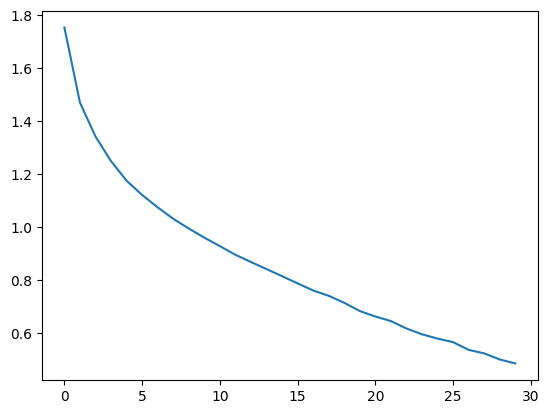

In [89]:
plt.plot(number_epoch,cur_loss)
plt.show()

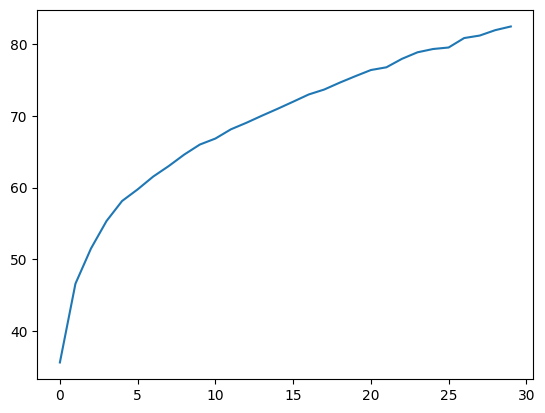

In [90]:
plt.plot(number_epoch,cur_accuracy)
plt.show()

# Evaluation #

In [ ]:
mlp.eval()
loss = nn.CrossEntropyLoss()
accuracy = 0.0
for x_data,y_data in x_val_dataloader:
    y_pred = mlp(x_data).squeeze()
    l = loss(y_pred,y_data)
    _,id = torch.max(y_pred.data,1)
    accuracy += torch.sum(id == y_data.data)/128
p = accuracy.item() / len(x_test_dataloader) *100
print("The Validation set has an accuracy %.1f %%" %p)

# Testing # 

In [ ]:
loss = nn.CrossEntropyLoss()
accuracy = 0.0
for x_data,y_data in x_test_dataloader:
    y_pred = mlp(x_data).squeeze()
    l = loss(y_pred,y_data)
    _,id = torch.max(y_pred.data,1)
    accuracy += torch.sum(id == y_data.data)/128
p = accuracy.item() / len(x_test_dataloader) *100
print("The Test set has an accuracy %.1f %%" %p)

# Demo #

In [79]:
img1,label1 = cifar10[11000]
img2,label2 = cifar10[15112]
img3,label3 = cifar10[37420]

In [80]:
im1 = trainData[11000]
_,id1 = torch.max(mlp(im1[0]),1)
im2 = trainData[15112]
_,id2 = torch.max(mlp(im2[0]),1)
im3 = trainData[37420]
_,id3 = torch.max(mlp(im3[0]),1)

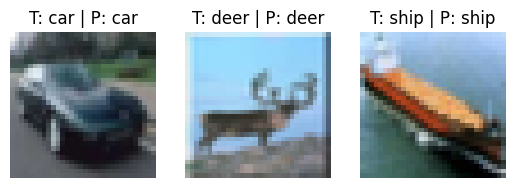

In [93]:
plt.figure()

plt.subplot(131)
plt.axis('off')
plt.title("T: %s | P: %s" %(classes[label1],classes[id1]))
plt.imshow(img1)

plt.subplot(132)
plt.axis('off')
plt.title("T: %s | P: %s" %(classes[label2],classes[id2]))
plt.imshow(img2)

plt.subplot(133)
plt.axis('off')
plt.title("T: %s | P: %s" %(classes[label3],classes[id3]))
plt.imshow(img3)

plt.show()

In [96]:
# Under 3 layer MLP limitation, 
# the model has an accuracy of about 50% on test set 
# after 30 epochs due to device limitation

# With 2 cn layer, 1 pool, 3 full conncect layers
# the cnn model has an accuracy of about 60% 
# # after 30 epochs due to device limitation